# Assignment 8: Programming a neural network layer & Scores

[Keras](https://keras.io) is a high-level deep-learning framework building on top of [TensorFlow](https://www.tensorflow.org). These frameworks follow the _symbol-to-symbol derivatives_ approach, i.e. automatically derive a computational graph to calculate derivatives. You just need to declare your inputs as TensorFlow variables and use TensorFlow operations on them to compute the forward pass.  

## Task 8.1

Work through the [Keras tutorial on custom layers](https://keras.io/guides/making_new_layers_and_models_via_subclassing) to learn how to create your own neural network layer.  
Create a custom Keras layer that computes Gaussian basis functions, i.e. a layer that maps an input vector $\mathbf x \in \mathbb R^n$ onto an output vector $\mathbf y = f(\mathbf x) \in \mathbb R^m$ as follows:
\begin{align}
  f: \mathbf x \in \mathbb R^n \mapsto \left[w_i \exp\left(-\frac{\|\mathbf x - \boldsymbol\mu_i\|^2}{\sigma_i^2}\right)\right]_{i=1..m} \in \mathbb R^m
\end{align}

Instead of projecting an input $\mathbf x$ onto a weight vector $\mathbf w$ as the standard neuron function $f(\mathbf x) = \sigma(\mathbf w \cdot \mathbf x + b)$ does, the Gaussian basis function becomes active (with weight $w_i$) for all inputs $\mathbf x$ close to a prototype $\boldsymbol \mu_i$. This activation quickly decays with increasing distance of $\mathbf x$ to $\boldsymbol \mu_i$. The parameter $\sigma_i$ controls the width of the Gaussian, i.e. the size of the active region.

For efficient tensor-based operations you need to correctly _broadcast_ the tensors for the difference operation: TensorFlow will pass an input matrix of shape `(batch size, input dim)` for $\mathbf X$, while you will have a matrix of centers $\boldsymbol \mu$ of shape `(input dim, #units)`. To correctly [broadcast](https://numpy.org/doc/stable/user/basics.broadcasting.html) them together, you will need Keras' [`expand_dims()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/expand_dims) function to extend $\mathbf X$'s shape to `(batch size, input dim, 1)`:

In [1]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

class RBFLayer(keras.layers.Layer):
    def __init__(self, units,
                 initializer=keras.initializers.RandomUniform(),
                 sigma_initializer=keras.initializers.Constant(value=1.0),
                 **kwargs):
        # call constructor of super class
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.initializer = initializer

        # sigma and w only depend on #units and thus can be initialized early
        self.sigma = self.add_weight(name='sigma_squared',
                                     shape=(self.units,),
                                     initializer=sigma_initializer,
                                     trainable=True)
        self.w = self.add_weight(name='w',
                                 shape=(self.units,),
                                 initializer=keras.initializers.Constant(value=1.0),
                                 trainable=True)

    def build(self, input_shape):
        # mu depends on input shape and thus its initialization needs to be deferred to build()
        super(RBFLayer, self).build(input_shape)
        # drop batch dim from shape and compute product of all remaining shape dims
        self.input_dim = numpy.prod(input_shape[1:])
        self.mu = self.add_weight(name='mu',
                                  shape=(self.input_dim, self.units),  
                                  initializer=self.initializer,
                                  trainable=True)

    def call(self, X):
        diff = K.expand_dims(K.reshape(X, (-1, self.input_dim))) - self.mu
        l2 = K.sum(diff**2, axis=1)
        return K.exp(-l2 / self.sigma) * self.w


class InitCentersRandom(keras.initializers.Initializer):
    """ Initializer to initialize centers of RBF network from random samples of the data set."""

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        print(shape, self.X.shape)
        assert shape[0] == numpy.prod(self.X.shape[1:])
        # create N random numbers in range [0..X.shape[0]], N=shape[1]
        idx = numpy.random.randint(self.X.shape[0], size=shape[1])
        # pick random data points from X and bring result into the right shape
        return K.reshape(K.transpose(self.X[idx]), shape)


# test RBF layer
x = tf.ones((1, 16, 16))  # input tensor of images with shape (batch size, width, height)
rbf = RBFLayer(3, initializer=keras.initializers.Constant(value=1.0))
print(rbf(x))

tf.Tensor([[1. 1. 1.]], shape=(1, 3), dtype=float32)


## Task 8.2

Compare the performance of such a Gaussian basis function layer with that of a standard [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer on the MNIST dataset.  
Hint: Utilize existing tutorials on setting up your first MNIST MLP with Keras, e.g. https://keras.io/guides/training_with_built_in_methods.

To achieve decent performance, you want to:
- Initialize the centers $\boldsymbol \mu_i$ from random data samples $\mathbf x$ (create a custom [initializer](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/Initializer))
- Initialize $\sigma_i$ to the typical in-class distance between data points.  
  Use [`scipy.spatial.distance_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html) to compute this statistics on a random selection of your input data.  
  (Doing it on the full dataset will probably exhaust your memory.)
- Initialize $w_i = 1$

Questions:
- How many parameters each of those networks have?
- Which network trains faster / easier?

In [2]:
# Load MNIST data set
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

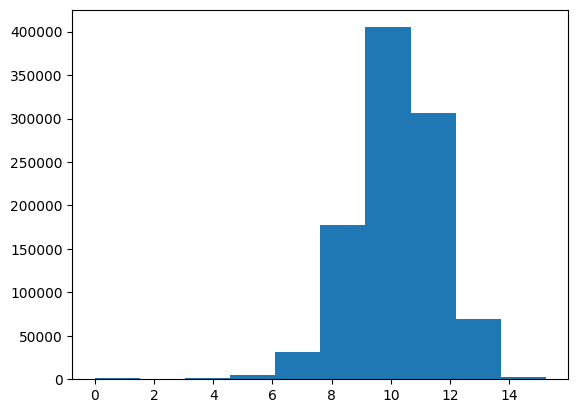

In [3]:
# compute typical distances between input vectors
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

sel = numpy.random.randint(x_train.shape[0], size=1000)
dists = distance_matrix(x_train[sel], x_train[sel])
plt.hist(dists.reshape((-1)));

In [4]:
# Declare input tensor
inputs = keras.Input(shape=x_train.shape[1:], name='mnist')

# Neural Network with a single hidden layer
x = keras.layers.Dense(64, activation='relu', name='hidden')(inputs)
outputs = keras.layers.Dense(10, name='output')(x)
model_nn = keras.Model(inputs=inputs, outputs=outputs)

# Gaussian Basis Function network, initialize centers from data, and sigmas from (2/3 * typical distance)^2
x = RBFLayer(64, name='rbf',
             initializer=InitCentersRandom(x_train),
             sigma_initializer=keras.initializers.Constant(value=6.0**2))(inputs)
outputs = keras.layers.Dense(10, name='output')(x)
model_rbf = keras.Model(inputs=inputs, outputs=outputs)

for model in [model_nn, model_rbf]:
    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                # Loss function to minimize
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                # List of metrics to monitor
                metrics=['sparse_categorical_accuracy'])

    print('\n# Fit model on training data')
    history = model.fit(x_train, y_train, batch_size=100, epochs=3,
                        validation_data=(x_val, y_val))

    print('# Evaluate on test data')
    results = model.evaluate(x_test, y_test, batch_size=100)

(np.int64(784), 64) (50000, 784)

# Fit model on training data
Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6401 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.2272 - val_sparse_categorical_accuracy: 0.9350
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9547
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1404 - val_sparse_categorical_accuracy: 0.9621
# Evaluate on test data
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.1576 - sparse_categorical_accuracy: 0.9552

# Fit model on training data
Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 2.1495 - sparse_categorical_accuracy: 0.2246 - val_loss: 1.5808 - val_sparse_categorical_accuracy: 0.6973
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.4084 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.8816 - 

# Scores

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)

## Least-Square Error and Maximum Likelihood Estimation

In this section, we'll explore the relationship between least-square error and maximum likelihood estimation under the assumption of Gaussian noise.

### Generating Data with Gaussian Noise

Let's start by generating some data from a linear model with Gaussian noise:

$$y = \theta^T x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

We'll visualize how the noise affects our observations.

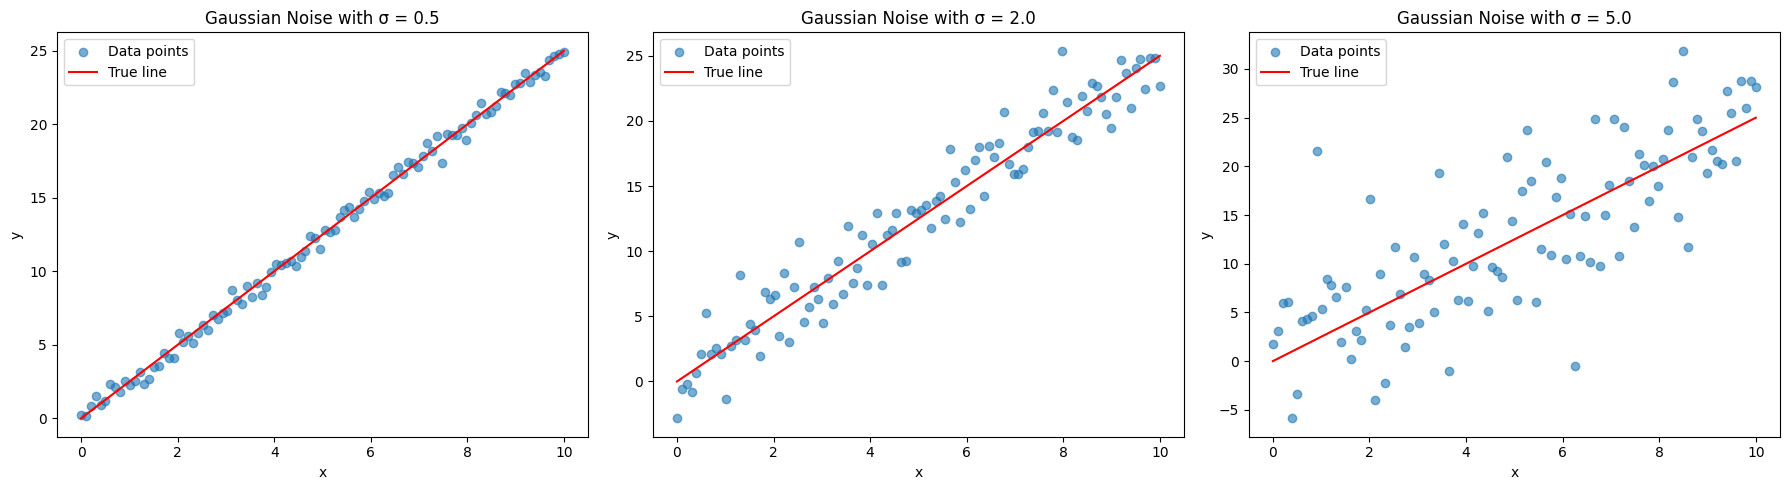

In [6]:
def generate_linear_data(theta, sigma, n_samples=100, x_range=(0, 10)):
    """Generate data from a linear model with Gaussian noise."""
    x = np.linspace(x_range[0], x_range[1], n_samples)
    noise = np.random.normal(0, sigma, n_samples)
    y = theta * x + noise
    return x, y

# Parameters
true_theta = 2.5  # True slope
sigma_values = [0.5, 2.0, 5.0]  # Different noise levels

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Generate and plot data with different noise levels
for i, sigma in enumerate(sigma_values):
    x, y = generate_linear_data(true_theta, sigma)
    
    # Plot the data points
    axes[i].scatter(x, y, alpha=0.6, label=f'Data points')
    
    # Plot the true line
    axes[i].plot(x, true_theta * x, 'r-', label='True line')
    
    # Add labels and title
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(f'Gaussian Noise with σ = {sigma}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Maximum Likelihood Estimation

Now, let's visualize how the likelihood function changes as we vary the parameter $\theta$. We'll see that the maximum likelihood estimate corresponds to the least-squares solution.
### Task 8.3: Implement the log_likelihood function. How does the log_likelihood and squared error change with different thetas?

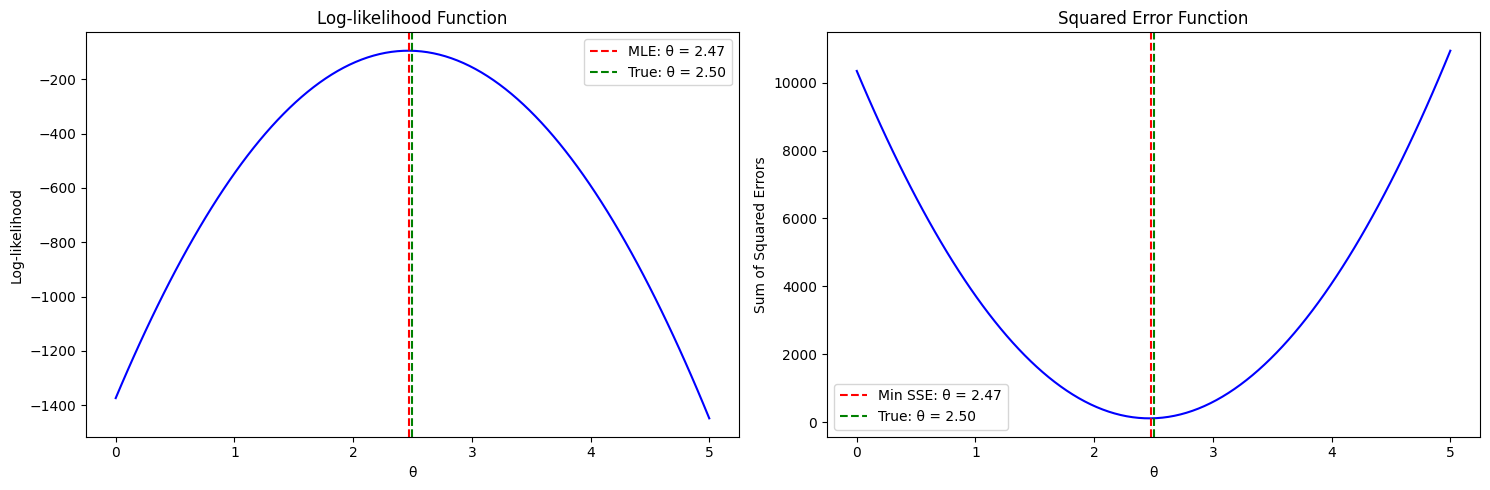

Maximum Likelihood Estimate: θ = 2.4747
Minimum Squared Error: θ = 2.4747
True Parameter: θ = 2.5000


In [7]:
def log_likelihood(theta, x, y, sigma):
    """Compute the log-likelihood for a linear model with Gaussian noise."""
    n = len(x)
    # Log-likelihood formula: -n/2 * log(2πσ²) - 1/(2σ²) * Σ(y - θx)²
    return -n/2 * np.log(2 * np.pi * sigma**2) - 1/(2 * sigma**2) * np.sum((y - theta * x)**2)

def squared_error(theta, x, y):
    """Compute the sum of squared errors."""
    return np.sum((y - theta * x)**2)

# Generate data
x, y = generate_linear_data(true_theta, 2.0, n_samples=50)

# Range of theta values to evaluate
theta_range = np.linspace(0, 5, 100)

# Compute log-likelihood and squared error for each theta
log_likelihoods = [log_likelihood(theta, x, y, 2.0) for theta in theta_range]
squared_errors = [squared_error(theta, x, y) for theta in theta_range]

# Find the maximum likelihood estimate and minimum squared error
mle_index = np.argmax(log_likelihoods)
mse_index = np.argmin(squared_errors)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot log-likelihood
ax1.plot(theta_range, log_likelihoods, 'b-')
ax1.axvline(theta_range[mle_index], color='r', linestyle='--', 
           label=f'MLE: θ = {theta_range[mle_index]:.2f}')
ax1.axvline(true_theta, color='g', linestyle='--', 
           label=f'True: θ = {true_theta:.2f}')
ax1.set_xlabel('θ')
ax1.set_ylabel('Log-likelihood')
ax1.set_title('Log-likelihood Function')
ax1.legend()

# Plot squared error
ax2.plot(theta_range, squared_errors, 'b-')
ax2.axvline(theta_range[mse_index], color='r', linestyle='--', 
           label=f'Min SSE: θ = {theta_range[mse_index]:.2f}')
ax2.axvline(true_theta, color='g', linestyle='--', 
           label=f'True: θ = {true_theta:.2f}')
ax2.set_xlabel('θ')
ax2.set_ylabel('Sum of Squared Errors')
ax2.set_title('Squared Error Function')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Likelihood Estimate: θ = {theta_range[mle_index]:.4f}")
print(f"Minimum Squared Error: θ = {theta_range[mse_index]:.4f}")
print(f"True Parameter: θ = {true_theta:.4f}")

### Interactive Demonstration

Let's create an interactive demonstration to see how the maximum likelihood estimate changes with different noise levels and sample sizes.

In [8]:
@interact(sigma=(0.5, 5.0, 0.5), n_samples=(10, 200, 10))
def plot_mle_interactive(sigma, n_samples):
    # Generate data
    x, y = generate_linear_data(true_theta, sigma, n_samples=n_samples)
    
    # Compute the analytical MLE (which is the same as least squares for linear regression)
    theta_mle = np.sum(x * y) / np.sum(x**2)
    
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Plot the data points
    plt.scatter(x, y, alpha=0.6, label='Data points')
    
    # Plot the true line
    plt.plot(x, true_theta * x, 'r-', label='True line')
    
    # Plot the MLE line
    plt.plot(x, theta_mle * x, 'g--', label='MLE line')
    
    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'MLE with σ = {sigma}, n = {n_samples}')
    plt.legend()
    
    # Print the results
    print(f"Maximum Likelihood Estimate: θ = {theta_mle:.4f}")
    print(f"True Parameter: θ = {true_theta:.4f}")
    print(f"Difference: {abs(theta_mle - true_theta):.4f}")
    
    plt.show()

interactive(children=(FloatSlider(value=2.5, description='sigma', max=5.0, min=0.5, step=0.5), IntSlider(value…

## Cross-Entropy Loss and Classification

In this section, we'll explore cross-entropy loss for classification problems, focusing on both binary and multi-class scenarios.

### Binary Classification with Sigmoid

First, let's revisit visualize the sigmoid function and understand its role in binary classification.

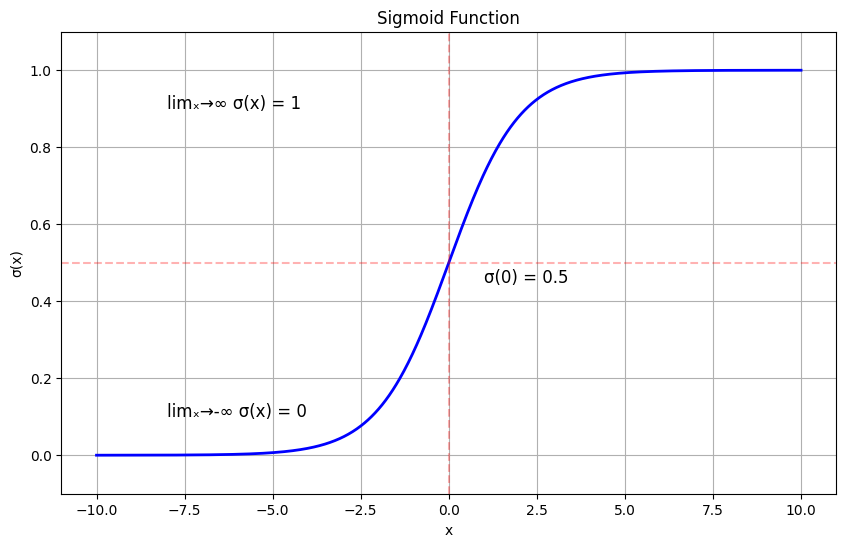

In [9]:
def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

# Range of values
x = np.linspace(-10, 10, 1000)
y = sigmoid(x)

# Plot the sigmoid function
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('x')
plt.ylabel('σ(x)')
plt.title('Sigmoid Function')
plt.grid(True)
plt.text(1, 0.45, 'σ(0) = 0.5', fontsize=12)
plt.text(-8, 0.9, 'limₓ→∞ σ(x) = 1', fontsize=12)
plt.text(-8, 0.1, 'limₓ→-∞ σ(x) = 0', fontsize=12)
plt.ylim(-0.1, 1.1)
plt.show()

### Binary Cross-Entropy Loss

Now, let's visualize the binary cross-entropy loss function for different true labels and predicted probabilities.
#### Task 8.4: Implement the binary cross entropy loss function.

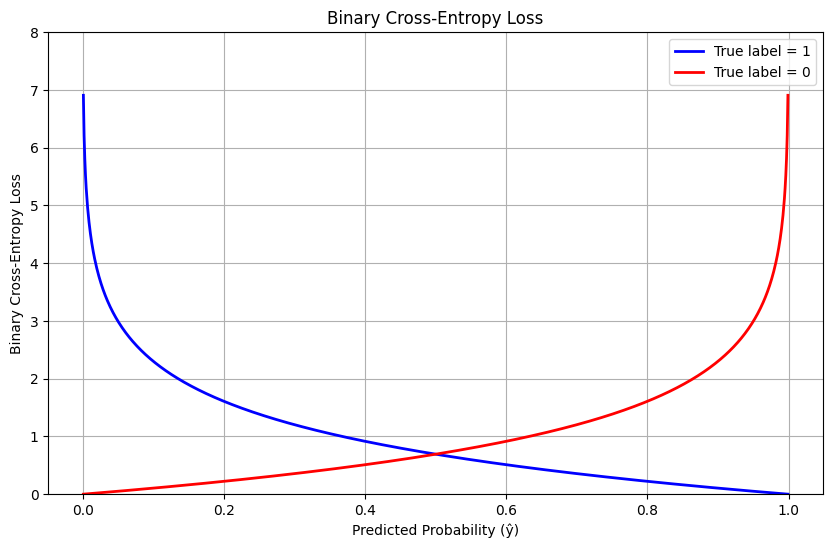

In [10]:
def binary_cross_entropy(y_true, y_pred):
    """Compute the binary cross-entropy loss."""
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

# Range of predicted probabilities
y_pred = np.linspace(0.001, 0.999, 1000)

# Compute loss for true label = 1 and true label = 0
loss_y1 = binary_cross_entropy(1, y_pred)
loss_y0 = binary_cross_entropy(0, y_pred)

# Plot the loss functions
plt.figure(figsize=(10, 6))
plt.plot(y_pred, loss_y1, 'b-', linewidth=2, label='True label = 1')
plt.plot(y_pred, loss_y0, 'r-', linewidth=2, label='True label = 0')
plt.xlabel('Predicted Probability (ŷ)')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 8)
plt.show()

### Softmax Function for Multi-class Classification

Let's visualize the softmax function for multi-class classification.

In [11]:
def softmax(x):
    """Compute the softmax function."""
    # Subtract max for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

@interact(a1=(-5.0, 5.0, 0.5), a2=(-5.0, 5.0, 0.5), a3=(-5.0, 5.0, 0.5))
def plot_softmax_interactive(a1, a2, a3):
    # Network outputs
    a = np.array([a1, a2, a3])
    
    # Compute softmax probabilities
    probs = softmax(a)
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(['Class 1', 'Class 2', 'Class 3'], probs, color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Probability')
    plt.title('Softmax Probabilities')
    
    # Add text labels
    for i, p in enumerate(probs):
        plt.text(i, p + 0.02, f'{p:.4f}', ha='center')
    
    # Print the network outputs and softmax probabilities
    print(f"Network Outputs: [{a1:.2f}, {a2:.2f}, {a3:.2f}]")
    print(f"Softmax Probabilities: [{probs[0]:.4f}, {probs[1]:.4f}, {probs[2]:.4f}]")
    print(f"Sum of Probabilities: {np.sum(probs):.4f}")
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='a1', max=5.0, min=-5.0, step=0.5), FloatSlider(value…

### Categorical Cross-Entropy Loss

Now, let's visualize the categorical cross-entropy loss for multi-class classification.

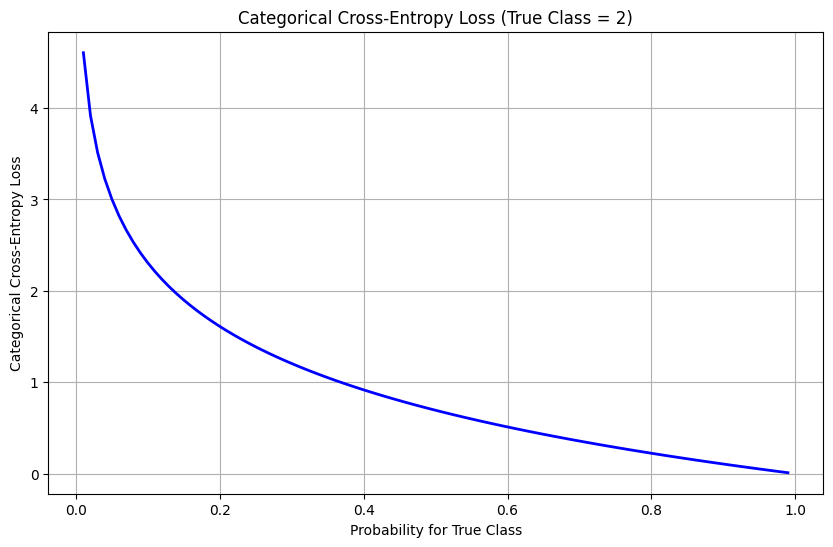

In [12]:
def categorical_cross_entropy(y_true, y_pred):
    """Compute the categorical cross-entropy loss."""
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred))

# Example: True class is 2 (one-hot encoded)
y_true = np.array([0, 1, 0])

# Let's see how the loss changes as we vary the probability for the true class
p_true_range = np.linspace(0.01, 0.99, 100)
losses = []

for p_true in p_true_range:
    # Distribute the remaining probability equally among the other classes
    p_others = (1 - p_true) / 2
    y_pred = np.array([p_others, p_true, p_others])
    losses.append(categorical_cross_entropy(y_true, y_pred))

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(p_true_range, losses, 'b-', linewidth=2)
plt.xlabel('Probability for True Class')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.title('Categorical Cross-Entropy Loss (True Class = 2)')
plt.grid(True)
plt.show()

### Entropy

Let's visualize the entropy of a binary distribution as we vary the probability of one outcome.

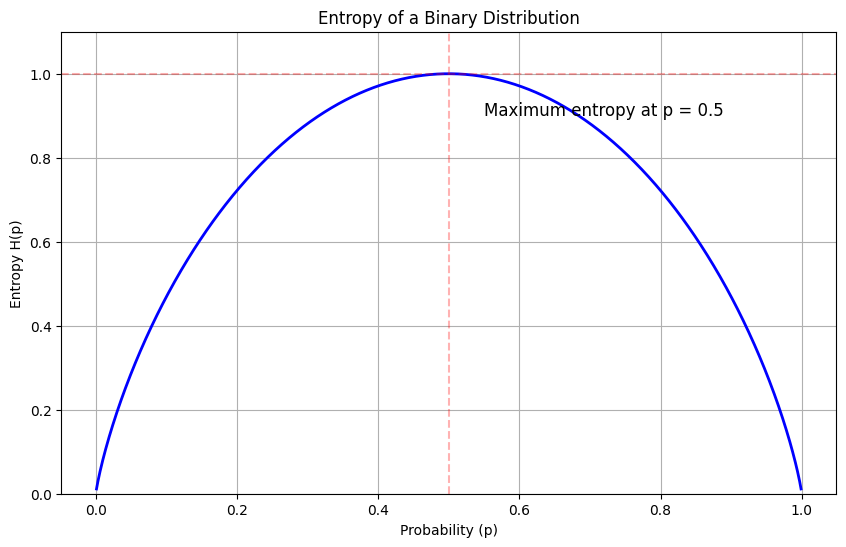

In [13]:
def entropy(p):
    """Compute the entropy of a binary distribution with probability p."""
    # Avoid log(0)
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Range of probabilities
p_range = np.linspace(0.001, 0.999, 1000)
entropies = [entropy(p) for p in p_range]

# Plot the entropy function
plt.figure(figsize=(10, 6))
plt.plot(p_range, entropies, 'b-', linewidth=2)
plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Probability (p)')
plt.ylabel('Entropy H(p)')
plt.title('Entropy of a Binary Distribution')
plt.grid(True)
plt.text(0.55, 0.9, 'Maximum entropy at p = 0.5', fontsize=12)
plt.ylim(0, 1.1)
plt.show()

### Cross-Entropy and KL Divergence

Now, let's visualize the relationship between entropy, cross-entropy, and KL divergence.

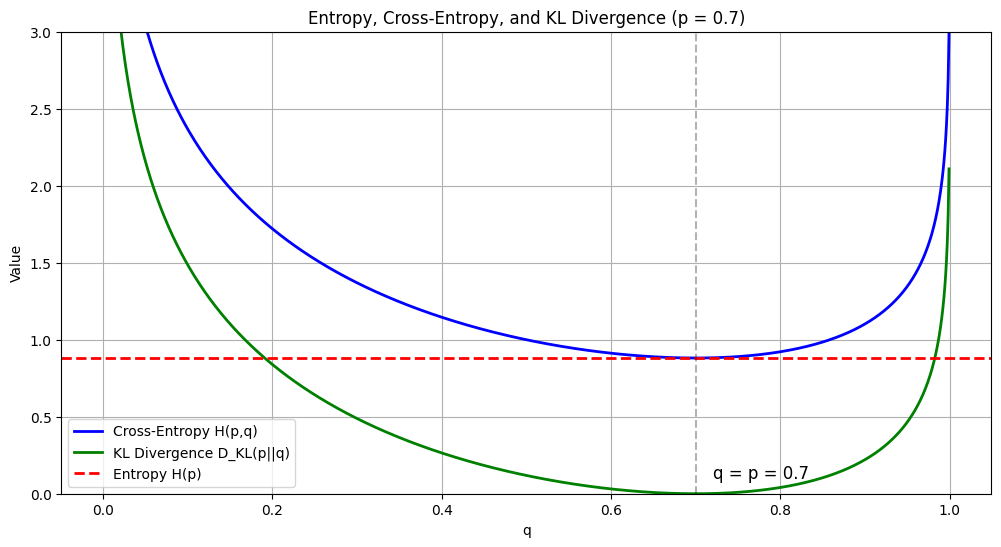

In [14]:
def cross_entropy(p, q):
    """Compute the cross-entropy between distributions p and q."""
    # Avoid log(0)
    if q == 0 or q == 1:
        return float('inf')
    return -p * np.log2(q) - (1 - p) * np.log2(1 - q)

def kl_divergence(p, q):
    """Compute the KL divergence between distributions p and q."""
    return cross_entropy(p, q) - entropy(p)

# Fix p and vary q
p = 0.7
q_range = np.linspace(0.001, 0.999, 1000)

# Compute entropy, cross-entropy, and KL divergence
h_p = entropy(p)
h_p_q = [cross_entropy(p, q) for q in q_range]
kl_p_q = [kl_divergence(p, q) for q in q_range]

# Plot the functions
plt.figure(figsize=(12, 6))
plt.plot(q_range, h_p_q, 'b-', linewidth=2, label='Cross-Entropy H(p,q)')
plt.plot(q_range, kl_p_q, 'g-', linewidth=2, label='KL Divergence D_KL(p||q)')
plt.axhline(y=h_p, color='r', linestyle='--', linewidth=2, label='Entropy H(p)')
plt.axvline(x=p, color='k', linestyle='--', alpha=0.3)
plt.xlabel('q')
plt.ylabel('Value')
plt.title(f'Entropy, Cross-Entropy, and KL Divergence (p = {p})')
plt.legend()
plt.grid(True)
plt.ylim(0, 3)
plt.text(p + 0.02, 0.1, f'q = p = {p}', fontsize=12)
plt.show()